This notebook can be run on mybinder: [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgricad-gitlab.univ-grenoble-alpes.fr%2Fchatelaf%2Fml-sicom3a/master?urlpath=lab/tree/notebooks/8_Trees_Boosting/N1_Classif_tree.ipynb/N3_c_Random_forests_Sonar_Data.ipynb)

## SONAR DATA

This is a dataset that describes sonar chirp returns bouncing off different services. The 60 input variables are the strength of the returns at different angles. It is a binary classification problem that requires a model to differentiate rocks from metal cylinders.

It is a well-understood dataset. All of the variables are continuous and generally in the range of 0 to 1. As such we will not have to normalize the input data, which is often a good practice with the Perceptron algorithm. The output variable is a string “M” for mine and “R” for rock, which will need to be converted to integers 1 and 0.

By predicting the class with the most observations in the dataset (M or mines) the Zero Rule Algorithm can achieve an accuracy of 53%.

You can learn more about this dataset at the UCI Machine Learning repository. You can download the dataset for free and place it in your working directory with the filename sonar.all-data.csv.


In [1]:
from csv import reader
import numpy as np

# Load a CSV file
def load_csv(filename):
    dataset = list()
    with open(filename, 'r') as file:
        csv_reader = reader(file)
        for row in csv_reader:
            if not row:
                continue
            dataset.append(row)
    return dataset

# Convert string column to float
def str_column_to_float(dataset, column):
    for row in dataset:
        row[column] = float(row[column].strip())
 
# Convert string column to integer
def str_column_to_int(dataset, column):
    class_values = [row[column] for row in dataset]
    unique = set(class_values)
    lookup = dict()
    for i, value in enumerate(unique):
        lookup[value] = i
    for row in dataset:
        row[column] = lookup[row[column]]
    return lookup

# load and prepare data
filename = 'sonar.all-data.csv'
dataset = load_csv(filename)
for i in range(len(dataset[0])-1):
    str_column_to_float(dataset, i)
# convert string class to integers
str_column_to_int(dataset, len(dataset[0])-1)
print("size of sonar dataset = {}".format(np.asarray(dataset).shape))

dataset_X=list()
dataset_y=list()
for i in range(len(dataset)):    
    dataset_X.append(dataset[i][:-1])
    dataset_y.append(dataset[i][-1])


size of sonar dataset = (208, 61)


### about Sonar data file
The file contains 111 patterns obtained by bouncing sonar signals off a metal cylinder at various angles and under various conditions. The file also contains 97 patterns obtained from rocks under similar conditions. The transmitted sonar signal is a frequency-modulated chirp, rising in frequency. The data set contains signals obtained from a variety of different aspect angles, spanning 90 degrees for the cylinder and 180 degrees for the rock. 

Each pattern is a set of 60 numbers in the range 0.0 to 1.0. Each number represents the energy within a particular frequency band, integrated over a certain period of time. The integration aperture for higher frequencies occur later in time, since these frequencies are transmitted later during the chirp. 

These experiments were conducted to evaluate the possibilities to detect mines or pipes on the sea floor. 

see http://archive.ics.uci.edu/ml/datasets/connectionist+bench+(sonar,+mines+vs.+rocks)

 ## Visualize a few realizations

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 1st sample label = 0
 200st sample label = 1


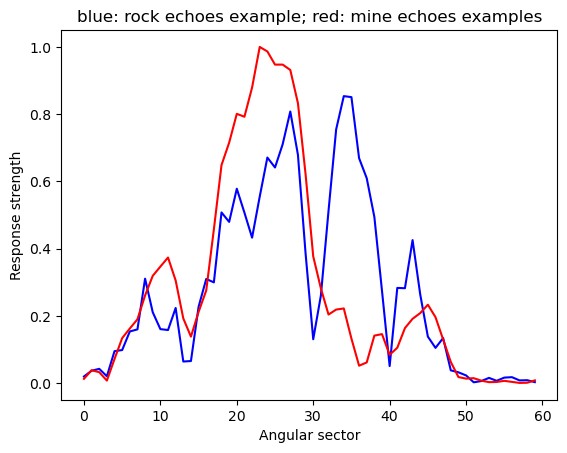

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

print(np.asarray(dataset)[:,-1])
plt.plot(np.asarray(dataset[0])[:-1],'b')
print(" 1st sample label = {}".format(dataset[0][-1]))
print(" 200st sample label = {}".format(dataset[200][-1]))
plt.plot(np.asarray(dataset[200])[:-1],'r')
plt.title('blue: rock echoes example; red: mine echoes examples')
plt.xlabel("Angular sector"); plt.ylabel("Response strength");

nb positive samples : (111, 60)
nb negative samples : (97, 60)


<Figure size 640x480 with 0 Axes>

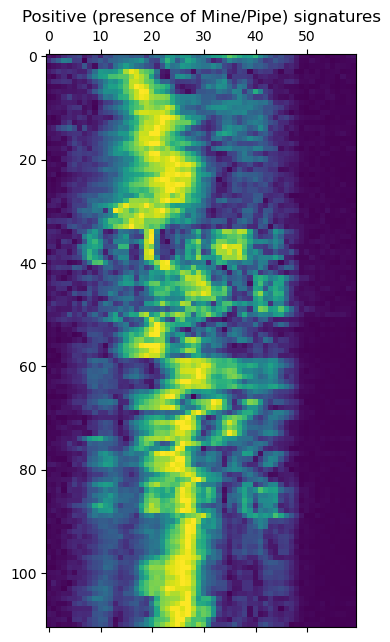

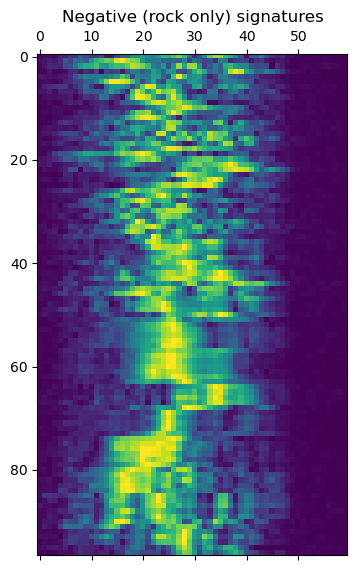

In [3]:
Positive=list()
Negative=list()
plt.figure(1)
for i in range(len(dataset)):
    
    r=dataset[i]; 
    if r[-1]== 1:
        Positive.append(r[:-1])
        #plt.subplot(211)
        #plt.plot(r[:-1])
    else: 
        Negative.append(r[:-1])
        #plt.subplot(212)
        #plt.plot(r[:-1])

plt.matshow(Positive)
plt.title('Positive (presence of Mine/Pipe) signatures')
print("nb positive samples :", np.asarray(Positive).shape)
plt.matshow(Negative)
plt.title('Negative (rock only) signatures')
print("nb negative samples :", np.asarray(Negative).shape)

## Compute a classification tree

In [4]:
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

nbdepth=8   # try 4 or 5 and decide wether more depth are usefull... 
estimator = tree.DecisionTreeClassifier(max_depth=nbdepth,criterion='entropy')


X_train, X_test, y_train, y_test = train_test_split(dataset_X, dataset_y, test_size=.2,random_state=0)
print("resp. length of X_train and X_test are {0} and {1} ".format([len(X_train)],[len(X_test)]))

estimator = estimator.fit(X_train, y_train)
estimator

resp. length of X_train and X_test are [166] and [42] 


DecisionTreeClassifier(criterion='entropy', max_depth=8)

## ...and visualize it

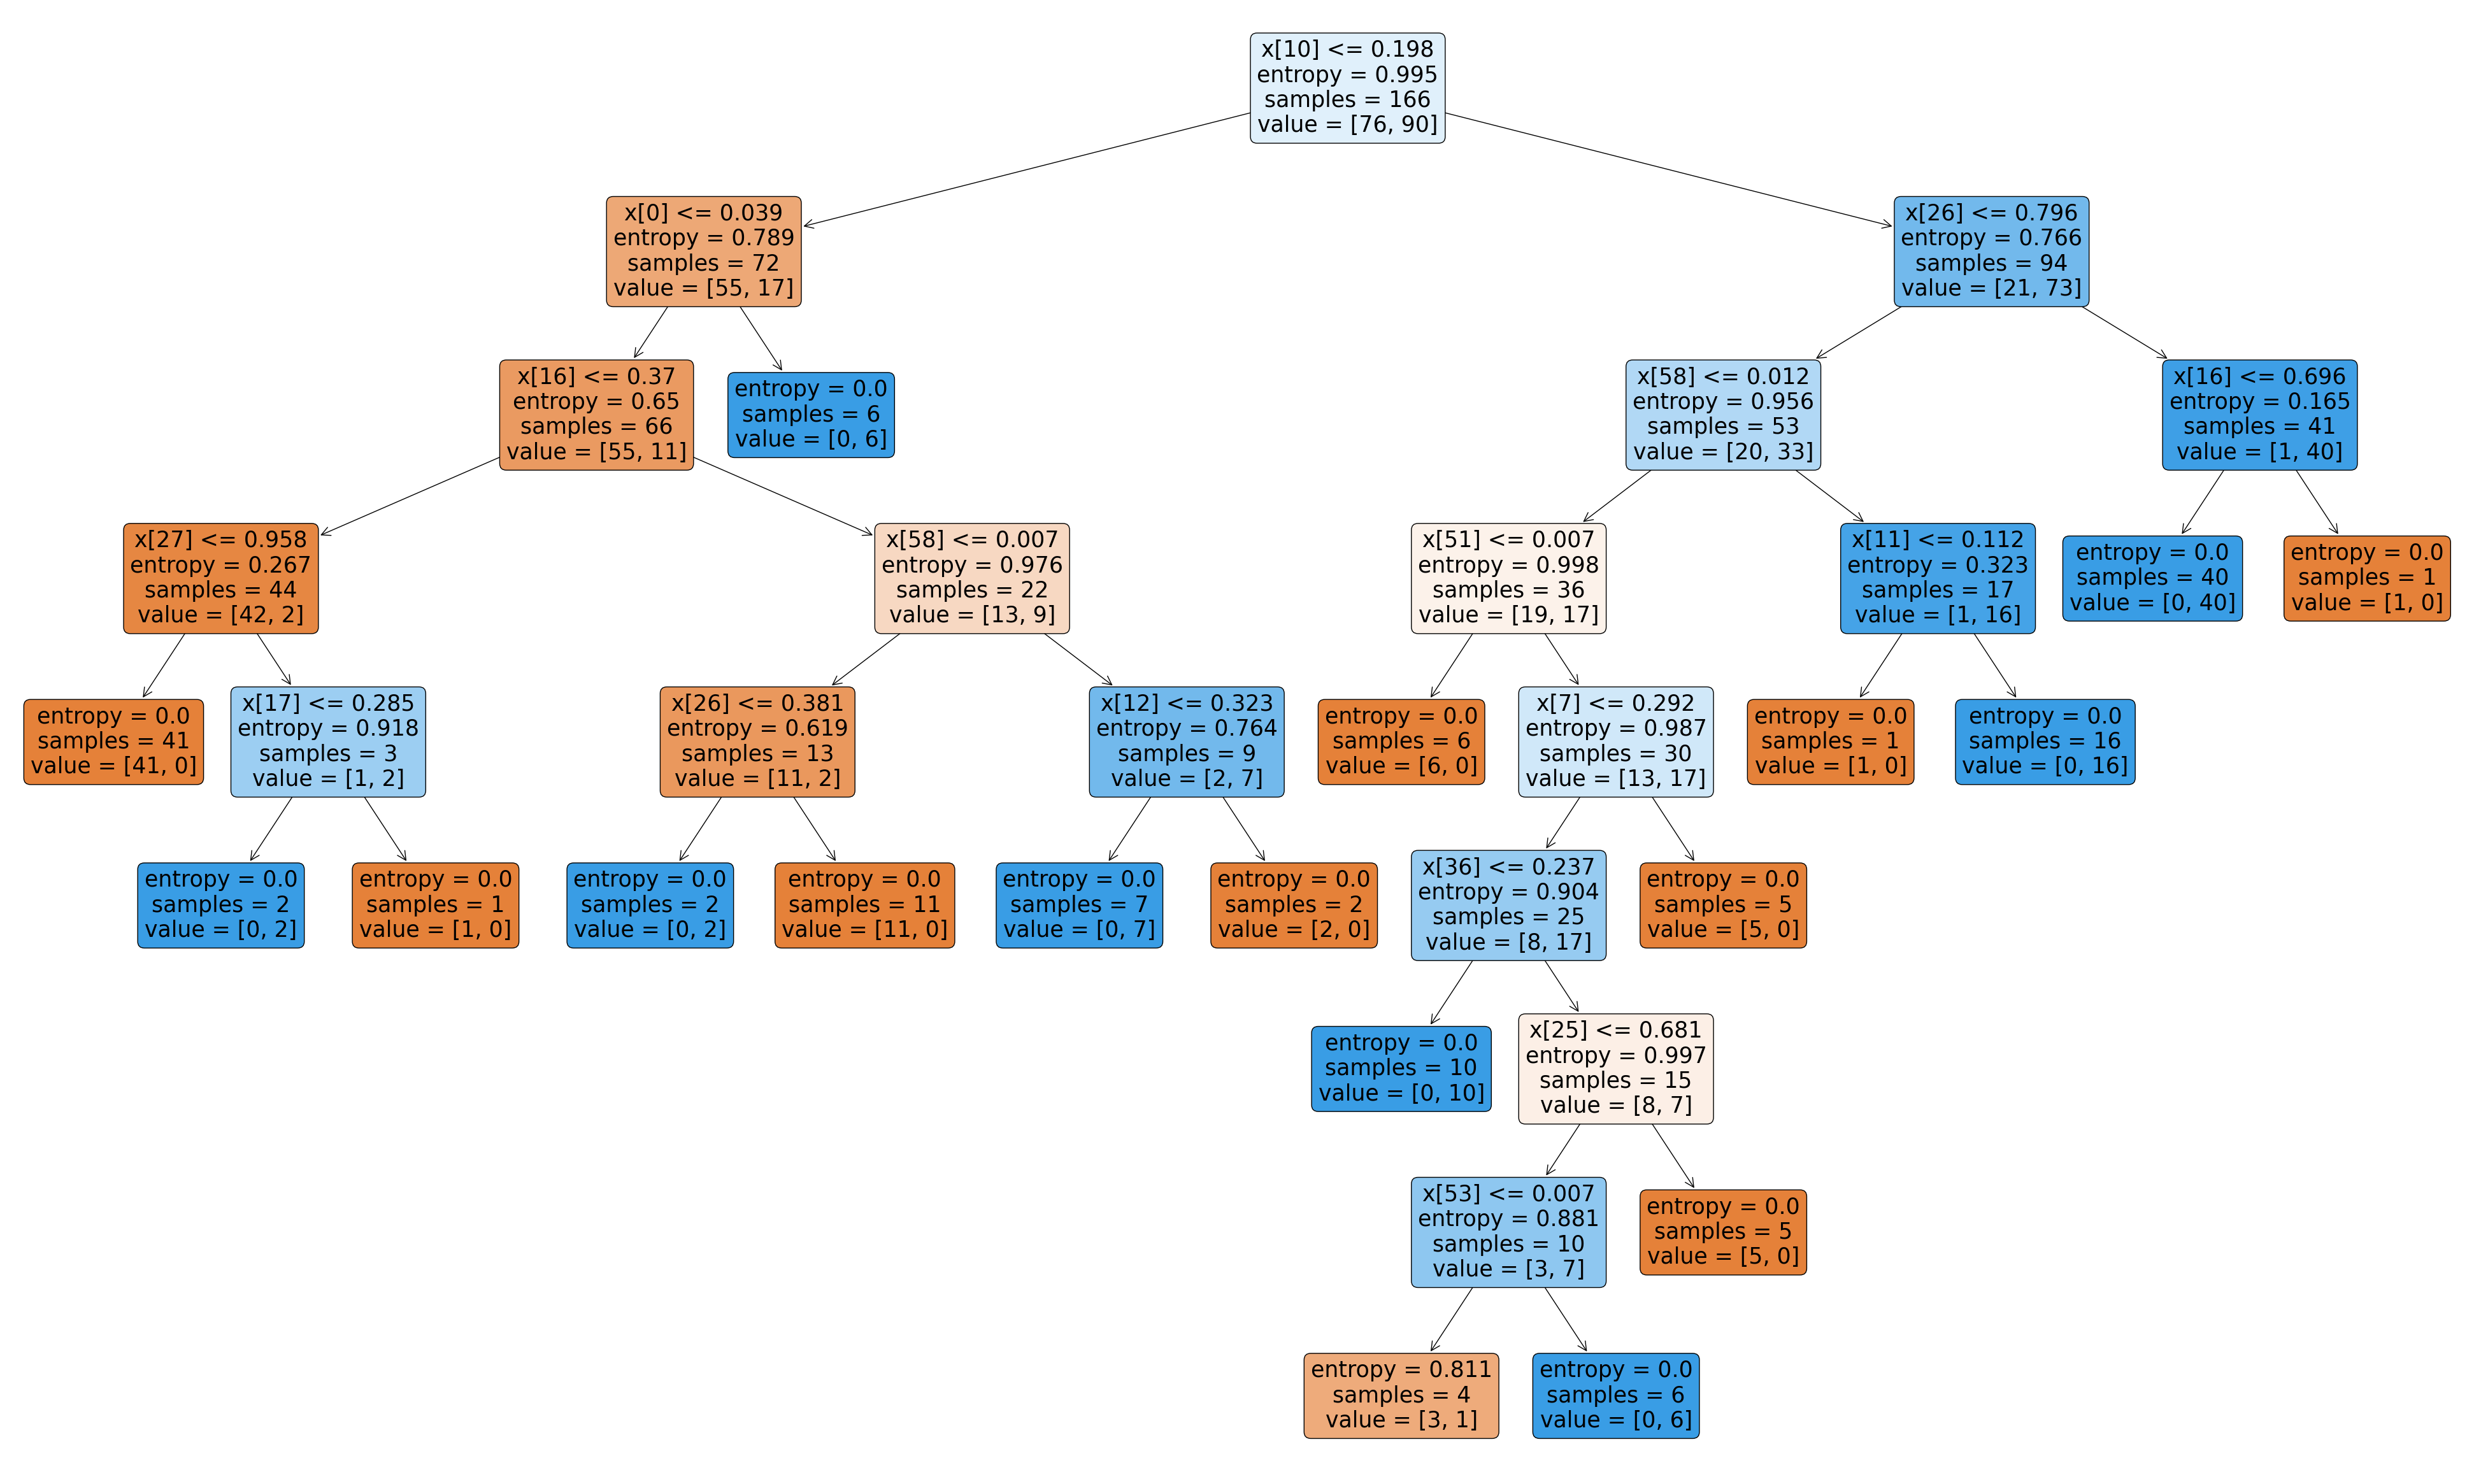

In [5]:
from sklearn.tree import plot_tree
plt.figure(figsize=(50,30))
a = plot_tree(estimator,
              filled=True, 
              rounded=True,fontsize=25)

## Evaluate its score

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=None)
scores = cross_val_score(estimator, dataset_X, dataset_y, cv=cv)
print("Mean Accuracy and 95 percent confidence interval : %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() *2))

Mean Accuracy and 95 percent confidence interval : 0.74 (+/- 0.13)


## Compute a random forest

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier


clf = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=None, max_features=4, min_samples_split=2, criterion='entropy')
scores = cross_val_score(clf, dataset_X, dataset_y, cv=10)
print("Mean Accuracy and 95 percent confidence interval RandomForest: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() *2)) 

clf = ExtraTreesClassifier(n_estimators=100, max_depth=None, random_state=None, max_features=4,min_samples_split=2, criterion='entropy')
scores = cross_val_score(clf, dataset_X, dataset_y, cv=10)
print("Mean Accuracy and 95 percent confidence interval ExtraTrees: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() *2))  

Mean Accuracy and 95 percent confidence interval RandomForest: 0.74 (+/- 0.22)
Mean Accuracy and 95 percent confidence interval ExtraTrees: 0.72 (+/- 0.19)


## ... and evaluate the importance or ranking  of the features

In [8]:
clf.fit(dataset_X, dataset_y)
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
print(std)
indices = np.argsort(importances)[::-1]
indices


[0.01636716 0.01386827 0.0134162  0.01573908 0.01718035 0.01304853
 0.01153791 0.01404904 0.02453394 0.02654034 0.04482205 0.03922735
 0.02925597 0.01300702 0.01654648 0.01832229 0.02153601 0.01547505
 0.0150485  0.01914154 0.02264376 0.01821077 0.02229218 0.0151511
 0.01392781 0.01358703 0.01702716 0.01786734 0.01743519 0.01391403
 0.01501203 0.01652054 0.01574642 0.01653222 0.0182406  0.02439381
 0.01922519 0.01489819 0.01412393 0.01362936 0.01324735 0.01672927
 0.01653786 0.02369807 0.02419608 0.01815232 0.02404256 0.02198196
 0.02743839 0.0128199  0.01815316 0.01882569 0.01235466 0.01433061
 0.01306656 0.01118342 0.01353121 0.01199232 0.01681723 0.01368965]


array([10, 11, 48, 12, 43, 35, 46, 20,  8, 44,  9, 22, 36, 47, 50, 26, 16,
       45, 19, 34, 51, 15, 27, 17, 21, 42, 37, 28, 53,  3, 18, 31, 41, 30,
       14, 23,  0, 33,  7, 39, 29, 58, 38, 32,  5,  4, 25, 24,  1, 59, 54,
       56, 49, 40,  2, 57, 52, 13,  6, 55])

Feature ranking:
1. feature 10 (0.038098)
2. feature 11 (0.037030)
3. feature 48 (0.027261)
4. feature 12 (0.026534)
5. feature 43 (0.024625)
6. feature 35 (0.023982)
7. feature 46 (0.022852)
8. feature 20 (0.022515)
9. feature 8 (0.022162)
10. feature 44 (0.022151)


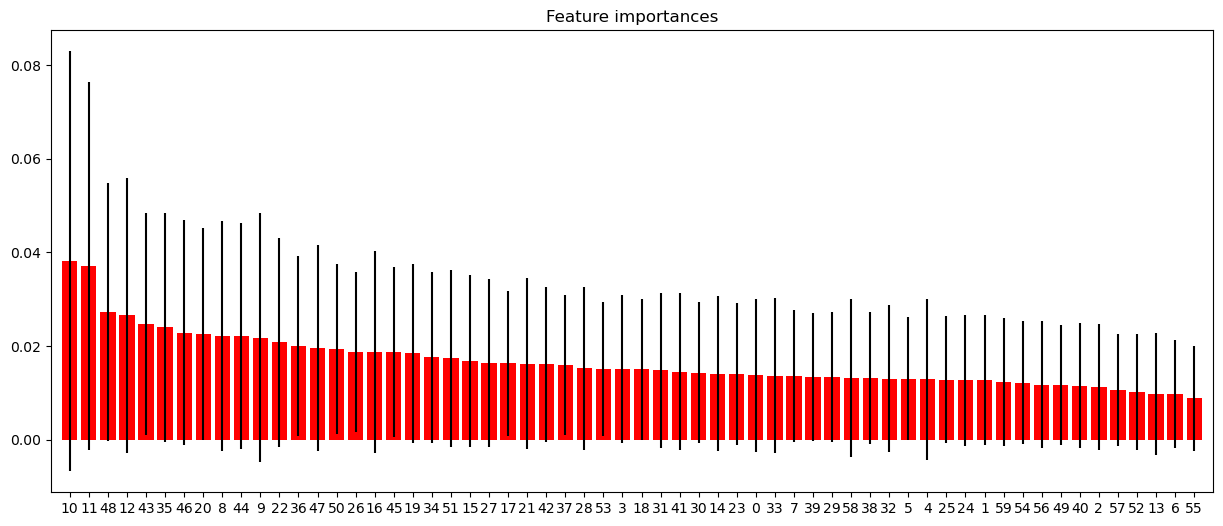

In [9]:

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    # Plot the feature importances of the forest
plt.figure(figsize=(15,6))
plt.title("Feature importances")
plt.bar(range(np.asarray(dataset_X).shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks( range( np.asarray(dataset_X).shape[1]) , indices)
plt.xlim([-1, np.asarray(dataset_X).shape[1]])

plt.show()
